# Projeto de NLP

O obejtivo deste projeto é coletar avaliações de um produto selecionado, contendo texto e nota e treinar classificadores de forma a avaliar suas performances.
Os classificadores deverão ser:

*   SVM + bow
*   SVM + embeddings
*   BERT

Além disso cada classificador deve ser analisado através de métricas de performance como acurácia, F1-score, precision, recall e etc.

Alunos:

*   Gabriel Souza Marques





In [ ]:
!pip install -q -U "tensorflow==2.8.*"

In [ ]:
from google.colab import userdata
import os
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import re
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import official.nlp.optimization
from official import nlp
from official.nlp import bert
import official.nlp.bert.configs
import official.nlp.bert.bert_models
import official.nlp.bert.tokenization

nlp = spacy.load("en_core_web_sm")

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

seed = 42

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


# Dataset - Spotify User Reviews

Este conjunto de dados consiste em mais de 51.000 avaliações de usuários do aplicativo Spotify da Google Play Store (janeiro a julho de 2022). As avaliações foram coletadas para analisar os sentimentos e feedback dos usuários em relação ao aplicativo. Cada avaliação foi rotulada como "POSITIVE" ou "NEGATIVE" com base em seu sentimento. A distribuição dos sentimentos dentro do conjunto de dados é a seguinte:

*   **Avaliações positivas: 56% do total de avaliações**
*   **Avaliações negativas: 44% do total de avaliações**

Este conjunto de dados pode ser usado para executar várias análises, como análise de sentimentos, análise de tendências ao longo do tempo e extração de recursos para obter insights sobre a experiência do usuário e a satisfação com o aplicativo Spotify. Ele serve como um recurso valioso para pesquisadores e desenvolvedores que desejam explorar as percepções do usuário e identificar áreas de melhoria para o aplicativo.

[Link para o dataset](https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset/data)

In [ ]:
# Download do dataset
!kaggle datasets download -d alexandrakim2201/spotify-dataset
!unzip spotify-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
spotify-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spotify-dataset.zip
replace DATASET.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DATASET.csv             


In [ ]:
df = pd.read_csv('DATASET.csv').sample(n=1000, random_state=seed) # Criando um dataframe com um subconjunto do dataset
df.head()

,Review,label
32533,I don't know what happened between now and las...,NEGATIVE
26097,AwesomeðŸ‘Œ to use for hands free ðŸ™Œ listeni...,POSITIVE
32054,love spotify. but when I close all my tabs aft...,NEGATIVE
35041,"Buggy, stops all of the sudden, cannot pause, ...",NEGATIVE
45509,"Very great quality, only backfire is that ever...",POSITIVE


# Explorando o dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 32533 to 20815
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   label   1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [ ]:
df.isnull().sum()

,0
Review,0
label,0


In [ ]:
# Removendo linhas com valores nulos
df = df.dropna(subset=['Review'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 32533 to 20815
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   label   1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [ ]:
df['label'].value_counts() # Verificação da distribuição de sentimentos/labels

,count
label,
NEGATIVE,553
POSITIVE,447


<Axes: xlabel='label', ylabel='count'>

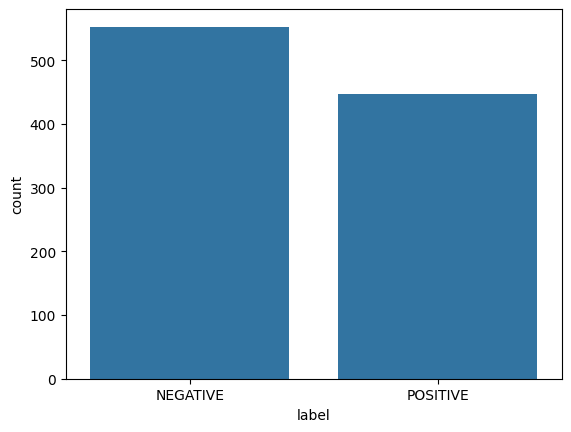

In [ ]:
sns.countplot(x='label', data=df)

# Pré-processamento do texto

## Limpeza

A coluna "Reviews" do nosso conjunto de dados tem uma variedade de símbolos, pontuação, caracteres especiais etc. que não são de nossa exigência. Exemplo: , : ( ) ? . " ; ! - + = ~ % etc. não são úteis.

In [ ]:
def clean_text(text):
  text = re.sub(r'Ã[\x80-\xBF]+', ' ', text) # remove combinações que incluem "Ã" e caracteres especiais subsequentes
  text = re.sub(r'[^a-zA-Z\s]', ' ', text) # remove todos os caracteres que não sejam letras do alfabeto
  text = re.sub(r'\s+', ' ', text) # remove uma ou mais ocorrências consecutivas de espaços em branco
  text = text.strip() # remove todos os espaços em branco do início e do fim
  return text.lower() # converte tudo para lowercase

df['Review'] = df['Review'].apply(clean_text)
df.head()

,Review,label
32533,i don t know what happened between now and las...,NEGATIVE
26097,awesome to use for hands free listening to,POSITIVE
32054,love spotify but when i close all my tabs afte...,NEGATIVE
35041,buggy stops all of the sudden cannot pause cho...,NEGATIVE
45509,very great quality only backfire is that every...,POSITIVE


## Tokenização + Remoção de stopwords+ Lematização + Stemming

In [ ]:
stemmer = PorterStemmer()

def tokenize_text(text):
  return [stemmer.stem(token.lemma_) for token in nlp(text) if not token.is_stop]

df['tokens'] = df['Review'].apply(tokenize_text)
df['sentences'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,Review,label,tokens,sentences
32533,i don t know what happened between now and las...,NEGATIVE,"[don, t, know, happen, month, late, spotifi, t...",don t know happen month late spotifi take away...
26097,awesome to use for hands free listening to,POSITIVE,"[awesom, use, hand, free, listen]",awesom use hand free listen
32054,love spotify but when i close all my tabs afte...,NEGATIVE,"[love, spotifi, close, tab, second, spotifi, k...",love spotifi close tab second spotifi keep pla...
35041,buggy stops all of the sudden cannot pause cho...,NEGATIVE,"[buggi, stop, sudden, paus, choos, second, ski...",buggi stop sudden paus choos second skip curre...
45509,very great quality only backfire is that every...,POSITIVE,"[great, qualiti, backfir, old, song, play, mod...",great qualiti backfir old song play mode stay ...


# Extração de features

## Bag of words

In [ ]:
def apply_bow(df):
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(df['sentences'])
  return X.toarray()

X_bow = apply_bow(df)
X_bow.shape

(1000, 1723)

## Embeddings

In [ ]:
def transform(args):
  exemplos, dimension = args

  results = np.zeros((len(exemplos), dimension, 50))
  for i, sequence in enumerate(exemplos):
    results[i, :len(sequence), :] = sequence
  return results

def apply_embeddings(df):
  model_review = Word2Vec(df['tokens'], vector_size=50, window=5, min_count=1, workers=4)
  max_len = 0
  X = []

  for tokens in df['tokens']:
    if len(tokens) == 0:
      X.append(np.zeros((max_len, 50)))
    else:
      vetores = model_review.wv[tokens]
      max_len = max(max_len, len(vetores))
      X.append(vetores)

  return X, max_len

X_embeddings = transform(apply_embeddings(df))
nsamples, nx, ny = X_embeddings.shape
X_embeddings = X_embeddings.reshape((nsamples, nx*ny))
X_embeddings.shape

(1000, 2450)

# Splitting dataset

In [ ]:
y = df['label']

In [ ]:
Y_bert = [1 if label == 'POSITIVE' else 0 for label in y]

## Bag of words

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y, test_size=0.2, random_state=seed)

## Embeddings

In [ ]:
X_train_embeddings, X_test_embeddings, y_train_embeddings, y_test_embeddings = train_test_split(X_embeddings, y, test_size=0.2, random_state=seed)

# BERT

In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df, Y_bert, test_size=0.2, random_state=seed)

X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_train_bert, y_train_bert, test_size=0.25, random_state=seed)

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

max_sent_length = 500

def bert_encode(df, tokenizer):
  num_examples = len(df['Review'])

  review = tf.ragged.constant([
      encode_sentence(s[:max_sent_length], tokenizer)
      for s in df["Review"]])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * review.shape[0]
  input_word_ids = tf.concat([cls, review], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.ones_like(review)

  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"

tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"), do_lower_case=True)

In [ ]:
bert_train_enc = bert_encode(X_train_bert, tokenizer)
bert_train_labels = np.array(y_train_bert)

bert_validation_enc = bert_encode(X_val_bert, tokenizer)
bert_validation_labels = np.array(y_val_bert)

bert_test_enc = bert_encode(X_test_bert, tokenizer)
bert_test_labels  = np.array(y_test_bert)

# Treino e teste

## SVM + BOW

In [ ]:
model=SVC()

model.fit(X_train_bow, y_train_bow)
y_pred = model.predict(X_test_bow)

accuracy = accuracy_score(y_test_bow, y_pred)
f1 = f1_score(y_test_bow, y_pred, average='weighted')
precision = precision_score(y_test_bow, y_pred, average='weighted')
recall = recall_score(y_test_bow, y_pred, average='weighted')

print(f"SVM + bow Accuracy: {accuracy:.4f}")
print(f"SVM + bow F1-score: {f1:.4f}")
print(f"SVM + bow Precision: {precision:.4f}")
print(f"SVM + bow Recall: {recall:.4f}")

SVM + bow Accuracy: 0.8350
SVM + bow F1-score: 0.8344
SVM + bow Precision: 0.8372
SVM + bow Recall: 0.8350


## SVM + Embeddings

In [ ]:
model=SVC()

model.fit(X_train_embeddings, y_train_embeddings)
y_pred = model.predict(X_test_embeddings)

accuracy = accuracy_score(y_test_embeddings, y_pred)
f1 = f1_score(y_test_embeddings, y_pred, average='weighted')
precision = precision_score(y_test_embeddings, y_pred, average='weighted')
recall = recall_score(y_test_embeddings, y_pred, average='weighted')

print(f"SVM + embeddings Accuracy: {accuracy:.4f}")
print(f"SVM + embeddings F1-score: {f1:.4f}")
print(f"SVM + embeddings Precision: {precision:.4f}")
print(f"SVM + embeddings Recall: {recall:.4f}")

SVM + embeddings Accuracy: 0.7000
SVM + embeddings F1-score: 0.6977
SVM + embeddings Precision: 0.7023
SVM + embeddings Recall: 0.7000


# BERT

In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=2)

In [ ]:
# Set up epochs and steps
epochs = 10
batch_size = 32
eval_batch_size = 32

bert_train_data_size = len(bert_train_labels)
bert_steps_per_epoch = int(bert_train_data_size / batch_size)
bert_num_train_steps = bert_steps_per_epoch * epochs
bert_warmup_steps = int(epochs * bert_train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = official.nlp.optimization.create_optimizer(2e-5, num_train_steps=bert_num_train_steps, num_warmup_steps=bert_warmup_steps)

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
bert_classifier.fit(
      bert_train_enc, bert_train_labels,
      validation_data=(bert_validation_enc, bert_validation_labels),
      batch_size=batch_size,
      epochs=epochs)

Epoch 1/10
19/19 [==============================] - 578s 30s/step - loss: 0.6929 - accuracy: 0.5567 - val_loss: 0.6582 - val_accuracy: 0.6450
Epoch 2/10
19/19 [==============================] - 552s 29s/step - loss: 0.6543 - accuracy: 0.5967 - val_loss: 0.6312 - val_accuracy: 0.6750
Epoch 3/10
19/19 [==============================] - 542s 29s/step - loss: 0.5640 - accuracy: 0.7183 - val_loss: 0.5907 - val_accuracy: 0.6900
Epoch 4/10
19/19 [==============================] - 541s 29s/step - loss: 0.5721 - accuracy: 0.6983 - val_loss: 0.5570 - val_accuracy: 0.7100
Epoch 5/10
19/19 [==============================] - 550s 29s/step - loss: 0.4869 - accuracy: 0.7850 - val_loss: 0.5330 - val_accuracy: 0.7350
Epoch 6/10
19/19 [==============================] - 555s 29s/step - loss: 0.3937 - accuracy: 0.8383 - val_loss: 0.4473 - val_accuracy: 0.8150
Epoch 7/10
19/19 [==============================] - 548s 29s/step - loss: 0.3459 - accuracy: 0.8633 - val_loss: 0.4735 - val_accuracy: 0.8050
Epoch 

In [ ]:
result = bert_classifier(bert_test_enc, training=False)

In [ ]:
result = tf.argmax(result, axis=1).numpy()

In [ ]:
print(classification_report(bert_test_labels, result, target_names=['NEGATIVE', 'POSITIVE']))

              precision    recall  f1-score   support

    NEGATIVE       0.85      0.75      0.80       104
    POSITIVE       0.76      0.85      0.80        96

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200

